In [2]:
import os
import tqdm
from os.path import join as jp

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
customer_train = pd.read_csv('../data_like/customer_train.csv')
customer_test = pd.read_csv('../data_like/customer_test.csv')

In [4]:
stories_description = pd.read_csv('../data_like/stories_description.csv')

In [5]:
stories_reaction_train = pd.read_csv('../data_like/stories_reaction_train.csv')
stories_reaction_test = pd.read_csv('../data_like/stories_reaction_test.csv')

In [6]:
transactions = pd.read_csv('../data_like/transactions.csv')

# Collecting Dataset

In [7]:
users_history = {}
first_seen_idxs = []

for idx in tqdm.tqdm_notebook(stories_reaction_train.index.values):
    story_reaction = stories_reaction_train.loc[idx]
    
    customer_id = story_reaction.customer_id
    story_id = story_reaction.story_id
    
    if customer_id not in users_history.keys():
        users_history[customer_id] = []
    
    if story_id in users_history[customer_id]:
        continue
    else:
        users_history[customer_id].append(story_id)
        first_seen_idxs.append(idx)

In [8]:
stories_first_reaction_train = stories_reaction_train.loc[first_seen_idxs]

In [9]:
full_df = pd.merge(stories_first_reaction_train, customer_train, how='left', on='customer_id')

In [10]:
full_df.head()

,customer_id,story_id,event_dttm,event,product_0,product_1,product_2,product_3,product_4,product_5,product_6,gender_cd,age,marital_status_cd,children_cnt,first_session_dttm,job_position_cd,job_title
0,15,138,2018-07-24 15:33:22,view,NaN,CLS,UTL,UTL,NaN,UTL,UTL,M,40.0,MAR,1.0,2012-06-06 09:57:21,17.0,НАЧАЛЬНИК ОТДЕЛА
1,15,202,2018-06-04 08:08:08,skip,NaN,CLS,UTL,UTL,NaN,UTL,UTL,M,40.0,MAR,1.0,2012-06-06 09:57:21,17.0,НАЧАЛЬНИК ОТДЕЛА
2,15,222,2018-06-17 13:44:45,skip,NaN,CLS,UTL,UTL,NaN,UTL,UTL,M,40.0,MAR,1.0,2012-06-06 09:57:21,17.0,НАЧАЛЬНИК ОТДЕЛА
3,15,379,2018-05-23 05:41:43,skip,NaN,CLS,UTL,UTL,NaN,UTL,UTL,M,40.0,MAR,1.0,2012-06-06 09:57:21,17.0,НАЧАЛЬНИК ОТДЕЛА
4,15,544,2018-07-25 02:16:29,view,NaN,CLS,UTL,UTL,NaN,UTL,UTL,M,40.0,MAR,1.0,2012-06-06 09:57:21,17.0,НАЧАЛЬНИК ОТДЕЛА


# Preprocessing

In [11]:
X = full_df.drop(columns='event')
y = full_df.event

In [12]:
np.any(X.isna())

True

In [13]:
np.any(y.isna())

False

In [14]:
from datetime import datetime

def transform_to_year(data, dt_column_name):
    years = ['nan'] * len(data)
    for i in tqdm.tqdm(range(len(data))):
        date = data[dt_column_name][i]
        if date != 'nan' and isinstance(date, str):
            years[i] = datetime.strptime(data[dt_column_name][i], '%Y-%m-%d %H:%M:%S').year
    data[dt_column_name] = years

In [15]:
X.story_id = X.story_id.astype('str')

products = list(map(lambda x: f'product_{x}', np.arange(7)))
X[products] = X[products].fillna('UPS')

X.gender_cd = X.gender_cd.fillna('B')

X.marital_status_cd = X.marital_status_cd.fillna('UMS')

X.children_cnt = X.children_cnt.fillna(int(X.children_cnt.mean()))
X.children_cnt = X.children_cnt.astype('str')

X.age = X.age.fillna(30)
X.age = X.age.astype('str')

X.job_position_cd = X.job_position_cd.fillna(-1)
X.job_position_cd = X.job_position_cd.astype('str')

transform_to_year(X, 'event_dttm')
X.event_dttm = X.event_dttm.astype('str')

transform_to_year(X, 'first_session_dttm')
X.first_session_dttm = X.first_session_dttm.astype('str')

X.drop(columns=['job_title'], inplace=True)

100%|██████████| 449802/449802 [00:13<00:00, 34008.59it/s]


In [16]:
np.any(X.isna())

False

In [17]:
dummy_X = pd.get_dummies(X)

In [18]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le_y = le.fit_transform(y)

In [19]:
dict(zip(le.classes_, le.transform(le.classes_)))

{'dislike': 0, 'like': 1, 'skip': 2, 'view': 3}

In [20]:
X_train, X_test, y_train, y_test = dummy_X[:301363], dummy_X[301363:], le_y[:301363], le_y[301363:]

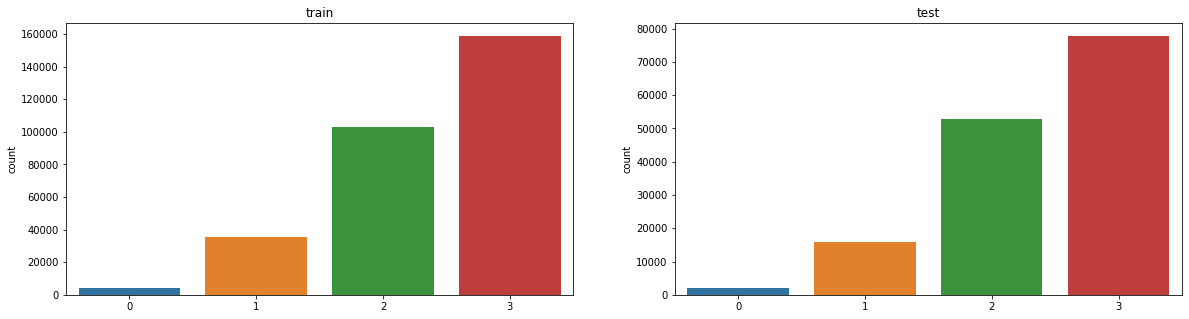

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

sns.countplot(y_train, ax=ax[0])
ax[0].set_title('train')

sns.countplot(y_test, ax=ax[1])
ax[1].set_title('test')

plt.show()

In [ ]:
from sklearn.model_selection import GroupKFold, GridSearchCV

In [ ]:
groups = X_train.customer_id

gkf = GroupKFold(n_splits=5).split(X_train, y_train, groups)

In [ ]:
X_train = X_train.drop(columns=['customer_id'])
X_test = X_test.drop(columns=['customer_id'])

In [22]:
from xgboost import XGBClassifier

In [23]:
xgbc = XGBClassifier()

In [24]:
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [26]:
y_pred = xgbc.predict(X_test)

In [32]:
pred_probas = xgbc.predict_proba(X_test)

In [70]:
from sklearn.metrics import accuracy_score

print(f'constant score: {accuracy_score(y_test, [3] * len(y_test))}')
print(f'predicts score: {accuracy_score(y_test, y_pred)}')

constant score: 0.5239795471540498
predicts score: 0.5464197414426127


In [73]:
from lib.metric import competition_metric, probas2scores

In [79]:
events = le.inverse_transform(y_test)

In [80]:
print(f'metric: {competition_metric(events, probas2scores(events, pred_probas))}')

metric: 1348.3154532133751
